In [0]:
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

def error_rate(y, p):
    return np.mean(y != p)

class AutoEncoder(object):
    def __init__(self, D, M, id):
        self.id = id
        self.build(D, M)

    def set_session(self, session):
        self.session = session

    def build(self, D, M):
        self.W = tf.Variable(tf.random_normal(shape=(D, M)))
        self.bh = tf.Variable(np.zeros(M).astype(np.float32))
        self.bo = tf.Variable(np.zeros(D).astype(np.float32))

        self.X_in = tf.placeholder(tf.float32, shape=(None, D))
        self.Z = self.forward_hidden(self.X_in)
        self.X_hat = self.forward_output(self.X_in)

        logits = self.forward_logits(self.X_in)
        self.cost = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=self.X_in)
        )
        self.train_op = tf.train.AdamOptimizer(1e-1).minimize(self.cost)

    def fit(self, X, epochs=1, batch_sz=100, show_fig=True):
        N, D = X.shape
        n_batches = N//batch_sz

        costs = []
        print('fitting autoencoder ', self.id)
        for i in range(epochs):
            print('epoch ', i+1, end=' ')
            X = shuffle(X)
            for j in range(n_batches):
                batch = X[j*batch_sz:(j*batch_sz + batch_sz)]
                _, c = self.session.run((self.train_op, self.cost), feed_dict={self.X_in: batch})
                costs.append(c)

            print('Cost: ', c)

        if show_fig:
            plt.plot(costs)
            plt.show()

    def forward_hidden(self, X):
        return tf.nn.sigmoid(tf.matmul(X, self.W) + self.bh)
    
    def forward_logits(self, X):
        Z = self.forward_hidden(X)
        return tf.matmul(Z, tf.transpose(self.W)) + self.bo

    def forward_output(self, X):
        return tf.nn.sigmoid(self.forward_logits(X))

    def transform(self, X):
        return self.session.run(self.Z, feed_dict={self.X_in: X})

    def predict(self, X):
        return self.session.run(self.X_hat, feed_dict={self.X_in: X})

class StackedAE(object):
    def __init__(self, D, hidden_layer_sizes, K):
        self.hidden_layers = []
        count = 0
        current_input = D
        for hl_size in hidden_layer_sizes:
            self.hidden_layers.append(AutoEncoder(current_input, hl_size, count))
            count += 1
            current_input = hl_size
        self.build_final_layer(D, hidden_layer_sizes[-1], K)

    def set_session(self, session):
        self.session = session

        for ae in self.hidden_layers:
            ae.set_session(session)

    def build_final_layer(self, D, M, K):
        self.W = tf.Variable(tf.random_normal(shape=(M, K)))
        self.b = tf.Variable(np.zeros(K).astype(np.float32))

        self.X = tf.placeholder(tf.float32, shape=(None, D))
        self.Y = tf.placeholder(tf.int32, shape=(None,))
        logits = self.forward(self.X)

        self.cost = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=self.Y)
        )
        self.train_op = tf.train.AdamOptimizer(1e-2).minimize(self.cost)
        self.predict_op = tf.argmax(logits, axis=1)

    def fit(self, x_train, y_train, x_test, y_test, epochs=1, batch_sz=100, show_fig=True):
        current_input = x_train
        for ae in self.hidden_layers:
            ae.fit(current_input, epochs=2, show_fig=False)
            current_input = ae.transform(current_input)
        
        N, D = x_train.shape
        n_batches = N//batch_sz

        costs = []
        print('supervised training: ')
        for i in range(epochs):
            print('epoch ', i+1, end=' ')
            x_train, y_train = shuffle(x_train, y_train)
            for j in range(n_batches):
                x_batch = x_train[j*batch_sz:(j*batch_sz + batch_sz)]
                y_batch = y_train[j*batch_sz:(j*batch_sz + batch_sz)]
                self.session.run(self.train_op, feed_dict={self.X: x_batch, self.Y: y_batch})
                c, p = self.session.run((self.cost, self.predict_op), feed_dict={self.X: x_test, self.Y: y_test})
                costs.append(c)

            print('Cost: ', c, ' Error rate: ', error_rate(p, y_test))

        if show_fig:
            plt.plot(costs)
            plt.show()

    def forward(self, X):
        current_input = X
        for ae in self.hidden_layers:
            Z = ae.forward_hidden(current_input)
            current_input = Z

        return tf.matmul(Z, self.W) + self.b

In [0]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train, x_test
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

fitting autoencoder  0
epoch  1 Cost:  0.1172932


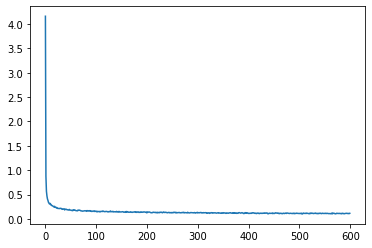

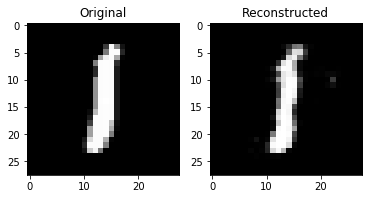

Generate another? (y/n)y


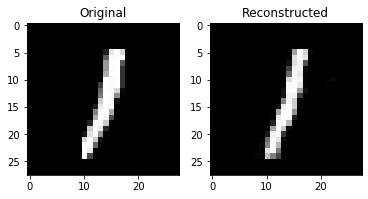

Generate another? (y/n)y


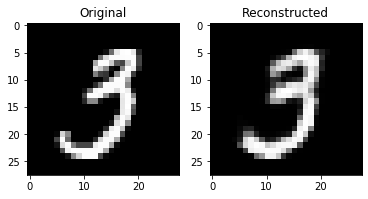

Generate another? (y/n)y


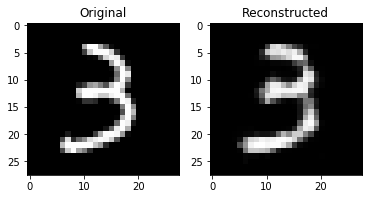

Generate another? (y/n)y


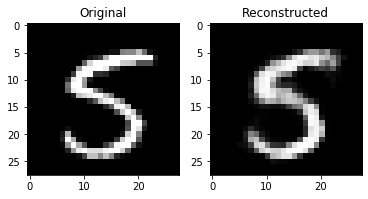

Generate another? (y/n)n


In [32]:
ae = AutoEncoder(x_train.shape[1], 300, 0)
init_op = tf.global_variables_initializer()
with tf.Session() as session:
    session.run(init_op)
    ae.set_session(session)
    ae.fit(x_train, epochs=1)

    done=False
    while not done:
        i = np.random.choice(len(x_test))
        x = x_test[i]
        y = ae.predict([x])
        plt.subplot(1, 2, 1)
        plt.imshow(x.reshape(28, 28), cmap='gray')
        plt.title('Original')
        
        plt.subplot(1, 2, 2)
        plt.imshow(y.reshape(28, 28), cmap='gray')
        plt.title('Reconstructed')

        plt.show()

        ans = input("Generate another? (y/n)")
        if ans and ans[0] in ('n' or 'N'):
            done = True

fitting autoencoder  0
epoch  1 Cost:  0.109392114
epoch  2 Cost:  0.10701842
fitting autoencoder  1
epoch  1 Cost:  0.016266419
epoch  2 Cost:  0.016695486
fitting autoencoder  2
epoch  1 Cost:  0.089083865
epoch  2 Cost:  0.08588259
supervised training: 
epoch  1 Cost:  0.19483924  Error rate:  0.0617
epoch  2 Cost:  0.12720652  Error rate:  0.0377
epoch  3 Cost:  0.12819338  Error rate:  0.037
epoch  4 Cost:  0.13076632  Error rate:  0.037
epoch  5 Cost:  0.12301515  Error rate:  0.0351


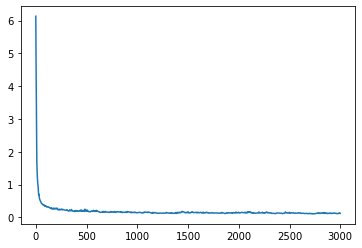

In [31]:
D = x_train.shape[1]
K = len(set(y_train))
dnn = StackedAE(D, [1000, 750, 500], K)

init_op = tf.global_variables_initializer()
with tf.Session() as session:
    session.run(init_op)
    dnn.set_session(session)
    dnn.fit(x_train, y_train, x_test, y_test, epochs=5)